In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

from network import Network
from perceptron import Perceptron
from layer import Layer
from tqdm import tqdm
import typing as tp
import matplotlib.pyplot as plt

sns.set_theme(rc={'figure.figsize': (8.25, 5.875), 'figure.dpi': 100, 'axes.labelpad': 2, 'savefig.pad_inches': .5})

In [2]:
os.getcwd()

'/home/duke_trystan/Documents/School/JHU/IntroToNeuralNetworks/Code/group_project'

In [3]:
df: pd.DataFrame = pd.read_csv(os.path.join('data', 'group_project_data.csv'))
df

,Data Item,LAC,SOW,TACA
0,1,0.90,0.87,1
1,2,1.81,1.02,0
2,3,1.31,0.75,1
3,4,2.36,1.60,0
4,5,2.48,1.14,0
5,6,2.17,2.08,1
6,7,0.41,1.87,0
7,8,2.85,2.91,1
8,9,2.45,0.52,0
9,10,1.05,1.93,0


<Axes: xlabel='TACA', ylabel='count'>

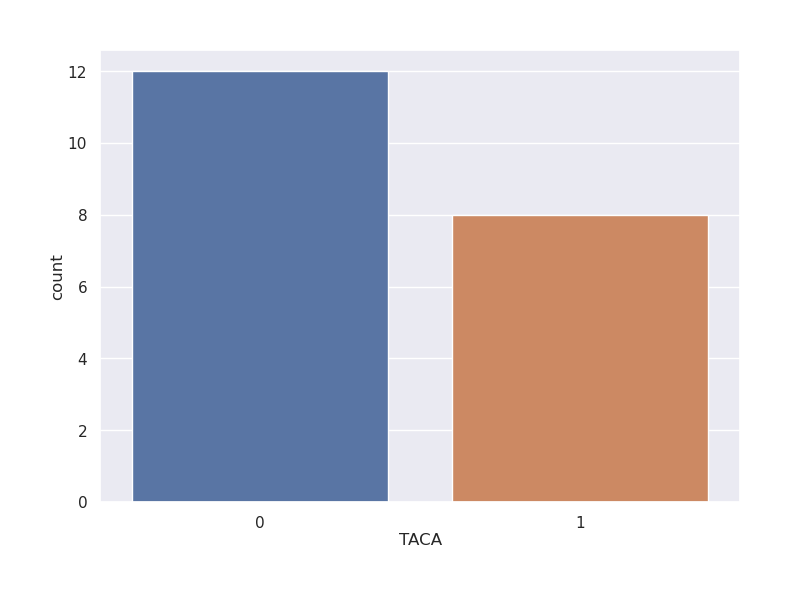

In [4]:
sns.countplot(data=df, x='TACA')

<Axes: xlabel='LAC', ylabel='SOW'>

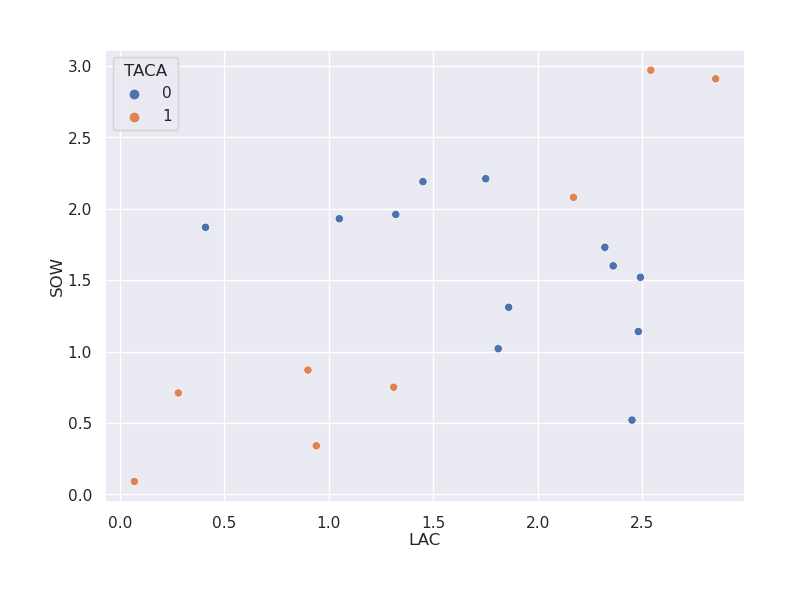

In [5]:
sns.scatterplot(data=df, x='LAC', y='SOW', hue='TACA')

In [6]:
def get_network(use_biases: bool) -> Network:
    return (Network()
    .add_layer(
        Layer(num_in_features=2,
              num_out_features=2,
              is_hidden_layer=True,
              # initial_weights=[np.ones(2) * 0.3, np.ones(2) * 0.3],
              use_biases=use_biases))
    .add_layer(
        Layer(num_in_features=2,
              num_out_features=1,
              is_hidden_layer=False,
              # initial_weights=[np.ones(2) * 0.8],
              use_biases=use_biases)))

In [7]:
x_cols: tp.List[str] = ['LAC', 'SOW']
y_cols: tp.List[str] = ['TACA']

In [8]:
def min_max_scale(a: np.ndarray) -> np.ndarray:
    min_val: np.ndarray = np.min(a, axis=0)
    max_val: np.ndarray = np.max(a, axis=0)
    return (a - min_val) / (max_val - min_val)

In [9]:
train_df: pd.DataFrame = pd.read_csv(os.path.join('data', 'train.csv'))
test_df: pd.DataFrame = pd.read_csv(os.path.join('data', 'test.csv'))

train_X: np.ndarray = min_max_scale(train_df[x_cols].values)
train_y: np.ndarray = train_df[y_cols].values

test_X: np.ndarray = min_max_scale(test_df[x_cols].values)
test_y: np.ndarray = test_df[y_cols].values

train_X.shape, train_y.shape

((10, 2), (10, 1))

In [10]:
def get_average_error(net: Network, x: np.ndarray, y: np.ndarray) -> float:
    tot_error: float = 0
    for i in range(x.shape[0]):
        net.feedforward(x[i])
        tot_error += net.get_total_error(y[i])
    return tot_error

def f1_score(pred: np.ndarray, true_y: np.ndarray) -> float:
    """
    Use F1 Score since it is better for unbalanced datasets, which our dataset is.
    :param pred:
    :param true_y:
    :return:
    """
    if isinstance(true_y, list):
        true_y: np.ndarray = np.array(true_y)
    if isinstance(pred, list):
        pred: np.ndarray = np.array(pred)
    tol: float = 1e-3

    def _is_equal(one: np.ndarray, two: tp.Union[np.ndarray, float]) -> np.ndarray:
        return np.abs(one - two) < tol

    true_positives: int = int(np.sum(np.logical_and(_is_equal(pred, 1), _is_equal(true_y, 1))))
    false_positives: int = int(np.sum(np.logical_and(_is_equal(pred, 1), _is_equal(true_y, 0))))
    false_negatives: int = int(np.sum(np.logical_and(_is_equal(pred, 0), _is_equal(true_y, 1))))
    denom: float = 2.0 * true_positives + false_positives + false_negatives
    if abs(denom - 0) < 1e-3:
        return 0
    return 2.0 * true_positives / denom

In [11]:
from sklearn.metrics import f1_score as good_f1_score

In [12]:
def _test_f1_score(pred: tp.Union[tp.List[float], np.ndarray], true_y: tp.Union[np.ndarray, tp.List[float]], tol: float = 1e-3) -> bool:
    my_f1: float = f1_score(pred, true_y)
    sklearn_f1: float = good_f1_score(y_pred=pred, y_true=true_y)
    print(f'My F1: {my_f1:.6f} | Sklearn: {sklearn_f1:.6f}')
    return abs(my_f1 - sklearn_f1) < tol

assert _test_f1_score([0, 0, 0], [1, 1, 1])
assert _test_f1_score([1, 1, 1], [0, 0, 0])
assert _test_f1_score([1, 1, 1], [1, 1, 1])
assert _test_f1_score([1, 1, 0, 0], [0, 0, 1, 1])
assert _test_f1_score([1, 1, 0, 0], [1, 1, 0, 0])
assert _test_f1_score([1, 1, 1, 0, 0], [1, 0, 1, 0, 1])

My F1: 0.000000 | Sklearn: 0.000000
My F1: 0.000000 | Sklearn: 0.000000
My F1: 1.000000 | Sklearn: 1.000000
My F1: 0.000000 | Sklearn: 0.000000
My F1: 1.000000 | Sklearn: 1.000000
My F1: 0.666667 | Sklearn: 0.666667


In [13]:
d: np.ndarray = np.array([[5, 1, 2], [0, 0, 0], [-5, -1, -2], [10, 2, 4], [11, 2, 4], [11, 2, -3]])
min_max_scale(d), d

(array([[0.625     , 0.66666667, 0.71428571],
        [0.3125    , 0.33333333, 0.42857143],
        [0.        , 0.        , 0.14285714],
        [0.9375    , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 0.        ]]),
 array([[ 5,  1,  2],
        [ 0,  0,  0],
        [-5, -1, -2],
        [10,  2,  4],
        [11,  2,  4],
        [11,  2, -3]]))

In [14]:
thresholds: np.ndarray = np.log10(np.logspace(1e-3, 1 - 1e-3, 100))
thresholds

array([0.001     , 0.01108081, 0.02116162, 0.03124242, 0.04132323,
       0.05140404, 0.06148485, 0.07156566, 0.08164646, 0.09172727,
       0.10180808, 0.11188889, 0.1219697 , 0.13205051, 0.14213131,
       0.15221212, 0.16229293, 0.17237374, 0.18245455, 0.19253535,
       0.20261616, 0.21269697, 0.22277778, 0.23285859, 0.24293939,
       0.2530202 , 0.26310101, 0.27318182, 0.28326263, 0.29334343,
       0.30342424, 0.31350505, 0.32358586, 0.33366667, 0.34374747,
       0.35382828, 0.36390909, 0.3739899 , 0.38407071, 0.39415152,
       0.40423232, 0.41431313, 0.42439394, 0.43447475, 0.44455556,
       0.45463636, 0.46471717, 0.47479798, 0.48487879, 0.4949596 ,
       0.5050404 , 0.51512121, 0.52520202, 0.53528283, 0.54536364,
       0.55544444, 0.56552525, 0.57560606, 0.58568687, 0.59576768,
       0.60584848, 0.61592929, 0.6260101 , 0.63609091, 0.64617172,
       0.65625253, 0.66633333, 0.67641414, 0.68649495, 0.69657576,
       0.70665657, 0.71673737, 0.72681818, 0.73689899, 0.74697

<Axes: xlabel='LAC', ylabel='SOW'>

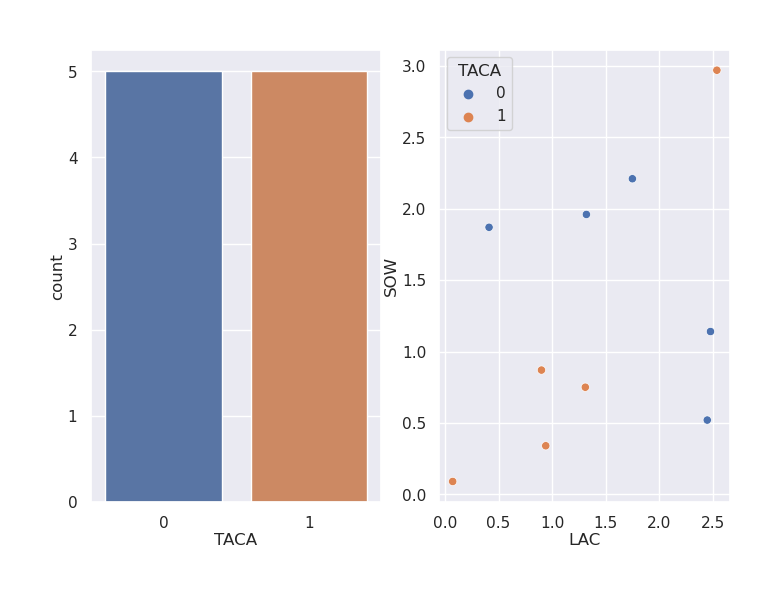

In [15]:
_, (ax_count, ax_scatter) = plt.subplots(1, 2)
sns.countplot(data=train_df, x='TACA', ax=ax_count)
sns.scatterplot(data=train_df, x='LAC', y='SOW', hue='TACA', ax=ax_scatter)

<Axes: xlabel='LAC', ylabel='SOW'>

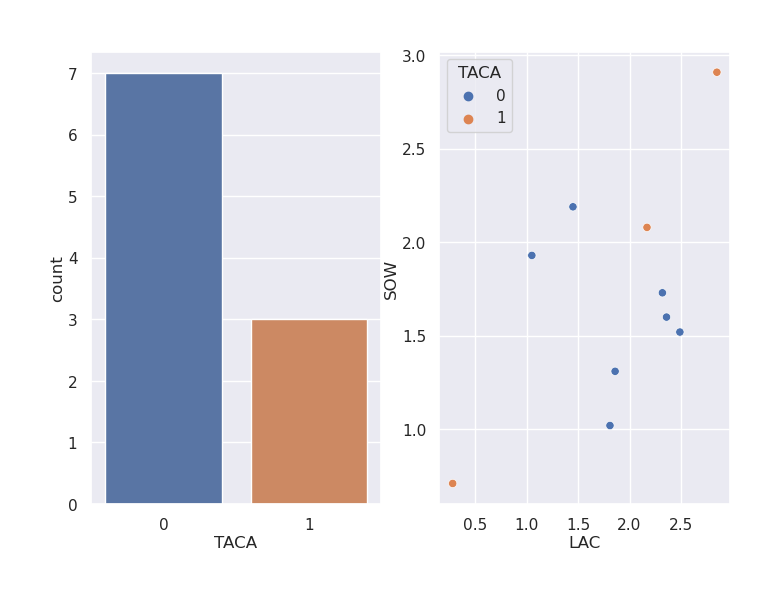

In [16]:
_, (ax_count, ax_scatter) = plt.subplots(1, 2)
sns.countplot(data=test_df, x='TACA', ax=ax_count)
sns.scatterplot(data=test_df, x='LAC', y='SOW', hue='TACA', ax=ax_scatter)

## Finding best seed

In [17]:
do_seed_analysis: bool = True

In [18]:
num_epochs: int = 30
lr: float = 1e-2
seeds: np.ndarray = np.arange(0, 10_000, 1).astype(int)
seed_history: tp.List[tp.Dict[str, tp.Union[int, float, str]]] = []
initial_threshold: float = 0.5

if do_seed_analysis:
    for seed in tqdm(seeds):
        np.random.seed(seed)
        for use_biases in [True, False]:
            network: Network = get_network(use_biases=use_biases)
            for epoch in range(num_epochs):
                predictions: tp.List[int] = []
                for i in range(train_X.shape[0]):
                    curr_out: np.ndarray = network.feedforward(train_X[i, :])
                    network.backprop(lr, train_y[i, :])
                    predictions.append(int(curr_out[0] < initial_threshold))
                curr_error: float = get_average_error(network, train_X, train_y)
                f1: float = f1_score(pred=np.array(predictions), true_y=train_y)
                seed_history.append({'epoch': epoch, 'error': curr_error, 'network-type': 'network', 'seed': seed, 'use-biases': use_biases, 'f1_score': f1})
    seed_df: pd.DataFrame = pd.DataFrame.frdef min_max_scale(a: np.ndarray) -> np.ndarray:
    min_val: np.ndarray = np.min(a, axis=0)
    max_val: np.ndarray = np.max(a, axis=0)
    return (a - min_val) / (max_val - min_val)om_records(seed_history)
seed_df if do_seed_analysis else ''

100%|██████████| 10000/10000 [19:22<00:00,  8.60it/s]


,epoch,error,network-type,seed,use-biases,f1_score
0,0,1.973891,network,0,True,0.0
1,1,1.970289,network,0,True,0.0
2,2,1.966657,network,0,True,0.0
3,3,1.962995,network,0,True,0.0
4,4,1.959303,network,0,True,0.0
...,...,...,...,...,...,...
599995,25,1.311705,network,9999,False,0.0
599996,26,1.311113,network,9999,False,0.0
599997,27,1.310526,network,9999,False,0.0
599998,28,1.309943,network,9999,False,0.0


/tmp/ipykernel_27274/3700792514.py:7: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=best_seed_df.query('use_biases'), x='rank', y='f1_score', ax=ax1, fill=True, thresh=0, levels=100, cmap="mako",)
/tmp/ipykernel_27274/3700792514.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,use_biases,f1_score,rank
seed,,,
3032,False,0.666667,1
0,False,0.000000,2
6669,False,0.000000,3
6668,True,0.000000,4
6668,False,0.000000,5
...,...,...,...
3333,True,0.000000,19996
3333,False,0.000000,19997
3332,True,0.000000,19998


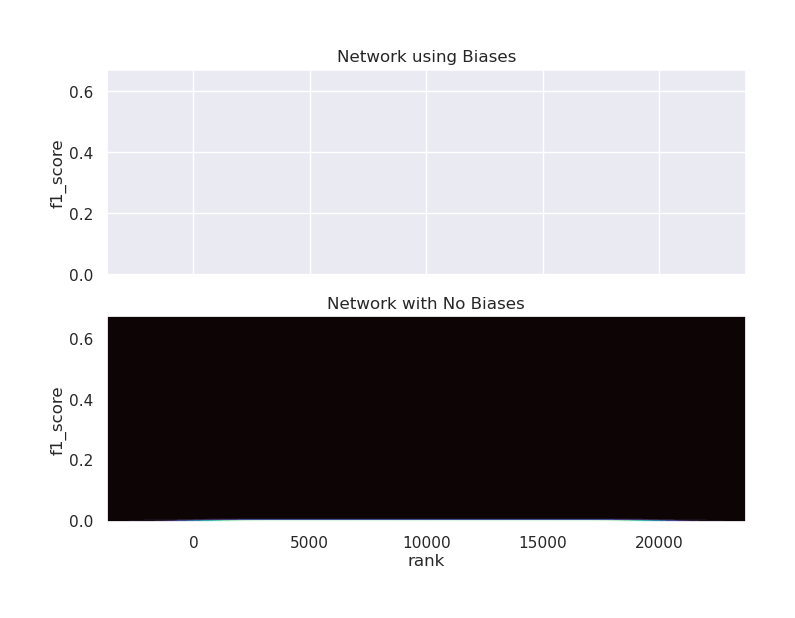

In [19]:
if do_seed_analysis:
    best_seed_df: pd.DataFrame = seed_df.query('epoch >= 29').groupby(by=['seed', 'use-biases']).aggregate({'f1_score': 'max'}).reset_index('use-biases').sort_values(by='f1_score', ascending=False).rename({'use-biases': 'use_biases'}, axis=1)
    best_seed_df['rank'] = np.arange(1, 1 + best_seed_df.shape[0])
    middle_error: float = np.median(best_seed_df['f1_score'])
    # best_seed_df.query('error < @middle_error and use_biases').shape, best_seed_df.query('error < @middle_error and not use_biases').shape
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
    sns.kdeplot(data=best_seed_df.query('use_biases'), x='rank', y='f1_score', ax=ax1, fill=True, thresh=0, levels=100, cmap="mako",)
    ax1.set_title('Network using Biases')
    sns.kdeplot(data=best_seed_df.query('not use_biases'), x='rank', y='f1_score', ax=ax2, fill=True, thresh=0, levels=100, cmap="mako",)
    ax2.set_title('Network with No Biases')
    fig.show()
best_seed_df if do_seed_analysis else ''

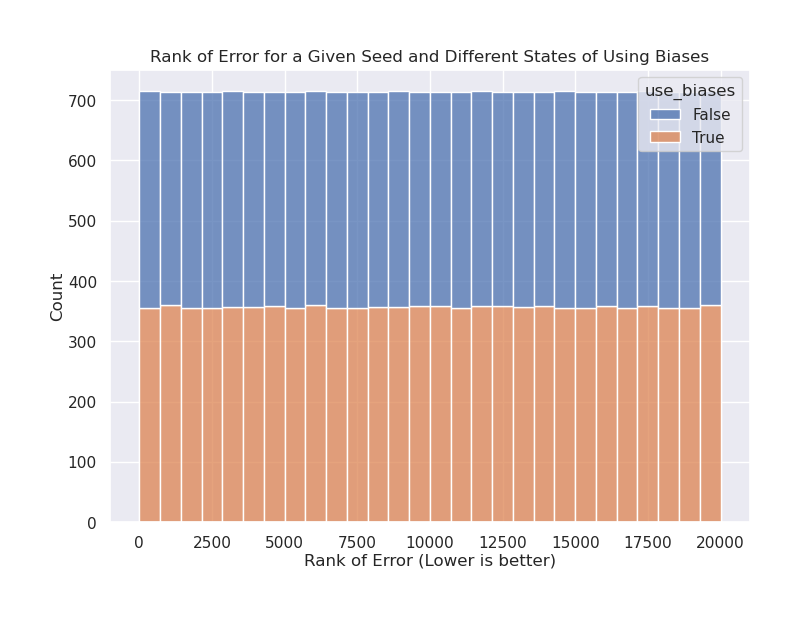

In [20]:
if do_seed_analysis:
    sns.histplot(data=best_seed_df, x='rank', hue='use_biases', multiple='stack')
    plt.title(f'Rank of Error for a Given Seed and Different States of Using Biases')
    plt.xlabel('Rank of Error (Lower is better)')

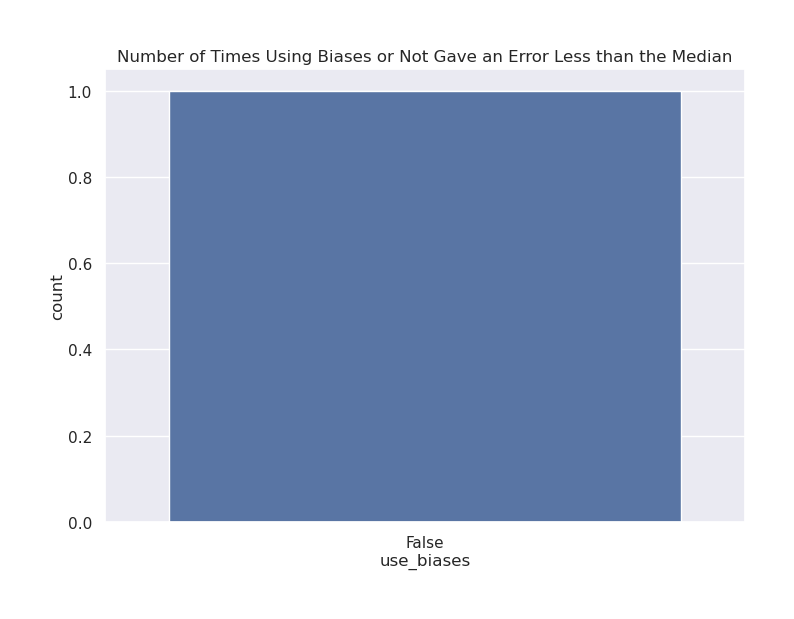

In [21]:
if do_seed_analysis:
    sns.countplot(data=best_seed_df.query('f1_score > @middle_error'), x='use_biases')
    plt.title('Number of Times Using Biases or Not Gave an Error Less than the Median')

In [22]:
best_seed_df.head(5) if do_seed_analysis else ''

,use_biases,f1_score,rank
seed,,,
3032,False,0.666667,1
0,False,0.000000,2
6669,False,0.000000,3
6668,True,0.000000,4
6668,False,0.000000,5


## End Seed

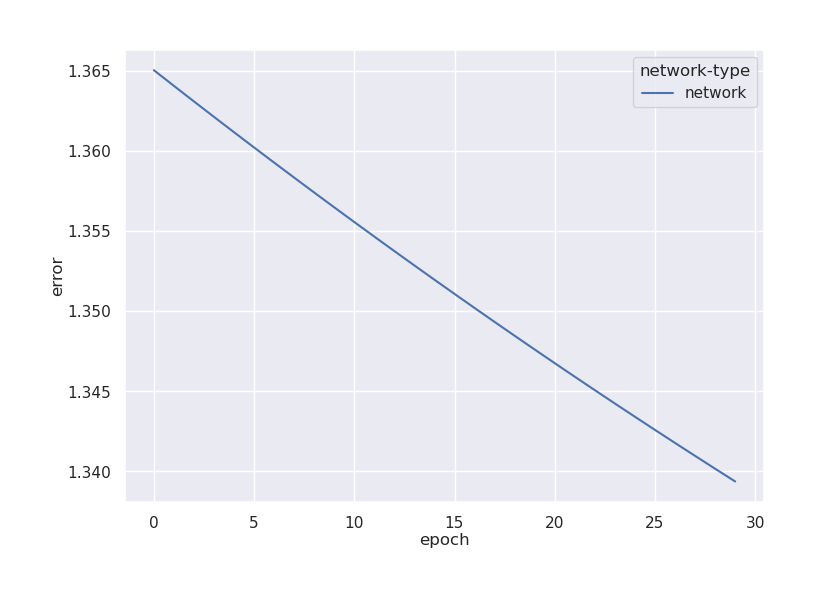

<Axes: xlabel='epoch', ylabel='f1_score'>

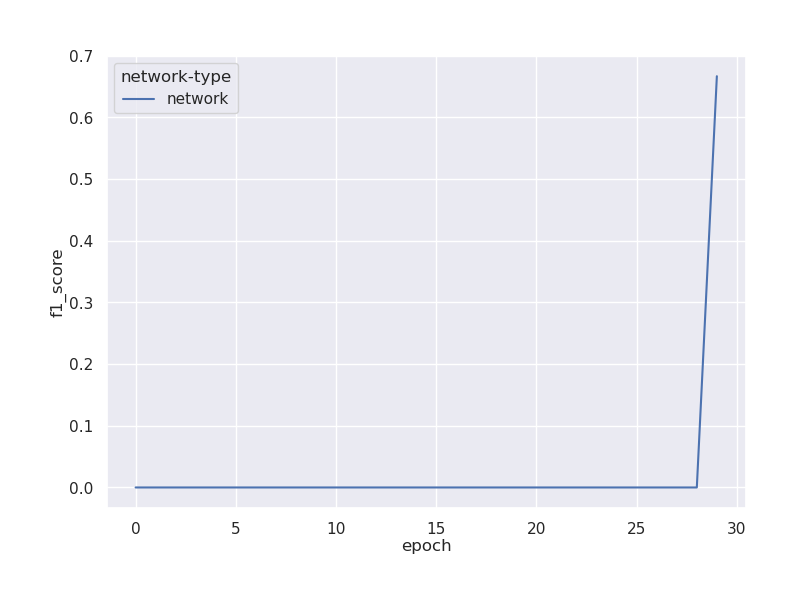

In [25]:
num_epochs: int = 30
lr: float = 1e-2
seeds: np.ndarray = np.arange(0, 100).astype(int)
error_history: tp.List[tp.Dict[str, tp.Union[int, float, str]]] = []

# Found to be the best one.
seed: int = 3032
use_biases: bool = False

np.random.seed(seed)
network: Network = get_network(use_biases=use_biases)

initial_threshold: float = 0.5

for epoch in range(num_epochs):
    is_last_epoch: bool = (num_epochs - epoch) <= 1
    given_outputs: tp.List[float] = []
    for i in range(train_X.shape[0]):
        curr_out: np.ndarray = network.feedforward(train_X[i, :])
        if is_last_epoch:
            given_outputs.append(curr_out[0])
        network.backprop(lr, train_y[i, :])
    curr_error: float = get_average_error(network, train_X, train_y)
    probs: np.ndarray = np.array(given_outputs)
    f1: float = f1_score(probs > initial_threshold, train_y)
    error_history.append({'epoch': epoch, 'error': curr_error, 'network-type': 'network', 'prob_pos': probs, 'prob_neg': 1 - probs, 'f1_score': f1})
error_df: pd.DataFrame = pd.DataFrame.from_records(error_history)
sns.lineplot(data=error_df.groupby(['epoch', 'network-type'], as_index=True).aggregate({'error': 'median'}).reset_index(), x='epoch', y='error', hue='network-type')
plt.show()
sns.lineplot(data=error_df.groupby(['epoch', 'network-type'], as_index=True).aggregate({'f1_score': 'median'}).reset_index(), x='epoch', y='f1_score', hue='network-type')

In [24]:
error_df.query('epoch >= 29').sort_values(by='f1_score')

,epoch,error,network-type,prob_pos,prob_neg,f1_score
29,29,1.330847,network,"[0.5933610456855739, 0.5965747601493313, 0.611...","[0.4066389543144261, 0.4034252398506687, 0.388...",0.666667
